# Functional enrichement analysis 
TO RUN BEFORE THE NOTEBOOK "MoByGenes_ML"


This notebook take the Duplicated gene screen (Dutcher, MoBy 1.0), look for functional enrichmnt using fisher test and gsea method. significant enrichment are added as categorical features to the biophysical features dataset. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import gseapy as gp
from gseapy import gseaplot
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib_venn import venn2, venn2_circles

In [2]:
DF = pd.read_csv('result_datasets/Moby_genes_features.csv', index_col=0)

In [3]:
Label = []
Num = []
for index, row in DF.iterrows():
    if row['logFC'] < 0 and row['FDR'] <= 0.05:
        Label.append('Toxic')
        Num.append(1)
    else:
        Label.append('Neutral')
        Num.append(0)
DF['Label'] = Label
DF['Numeric Label'] = Num

In [4]:
gene_name = pd.read_csv('datasets/Yeast_gene_mapped_ORF_name.table', sep= '\t', index_col=1)
DF = DF.join(gene_name)
DF = DF.rename_axis('Systematic name').reset_index()
DF['Gene'] = DF['Gene'].fillna(DF['Systematic name'])
DF = DF.set_index('Gene')

In [5]:
toxic = DF[DF['Numeric Label'] == 1]
neutral = DF[DF['Numeric Label'] == 0]

In [6]:
print('Detrimental genes that are essential', toxic['is essential'].sum() / toxic.shape[0] *100)
print('Neutral/beneficial genes that are essential',neutral['is essential'].sum() / neutral.shape[0] *100)

Detrimental genes that are essential 16.028708133971293
Neutral/beneficial genes that are essential 21.290523690773068


# Add prion category

In [7]:
prions = []
with open('datasets/prions_yeast_22_pRANK.fasta') as file:
    for line in file:
        if line[0] == '>':
            line = line.strip('>')
            gene , _ = line.split(' ')
            prions.append(gene.upper())
            

In [8]:
prion_lib = {'prions': prions}

## loading yeast gene ontology for gseapy

In [9]:
yeast =gp.get_library_name(organism='Yeast')
# download library or read a .gmt file
go_mf = gp.get_library(name='GO_Molecular_Function_2018', organism='Yeast')
go_bp = gp.get_library(name='GO_Biological_Process_2018', organism='Yeast')
go_cc = gp.get_library(name='GO_Cellular_Component_2018', organism='Yeast')
kegg = gp.get_library(name='KEGG_2019', organism='Yeast')
pheno = gp.get_library(name='Phenotype_AutoRIF', organism='Yeast')
phenoZ = gp.get_library(name='Phenotype_AutoRIF_Predicted_zscore', organism='Yeast')
pfam = gp.get_library(name='Pfam_Domains_2019', organism='Yeast')
ppi = gp.get_library(name='PPI_Hubs_BioGRID_2018', organism='Yeast')
inter_hub = gp.get_library(name='Gene_Interaction_Hubs_BioGRID_2018', organism='Yeast')
interpro = gp.get_library(name='InterPro_Domains_2019', organism='Yeast')
geneHubs = gp.get_library(name='Gene_Interaction_Hubs_BioGRID_2018', organism='Yeast')
wiki = gp.get_library(name='WikiPathways_2018', organism='Yeast')

In [10]:
gp.get_library_name(organism='Mouse')

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Diabetes_Perturbatio

In [11]:
# Other lists
in_complex = DF[DF['is in complex'] == 1]
essential = DF[DF['is essential'] == 1]
transMB = DF[DF['has transmembrane domain'] ==1]
disordered = DF[DF['has disordered region'] ==1]
haploinsuf = DF[DF['haploinsufficient'] == 1]
other_libraries = {'is in complex': list(in_complex.index), 'is essential': list(essential.index), 
                   'has transmembrane domain': list(transMB.index), 'has disordered region': list(disordered.index), 
                   'haploinsufficient': list(haploinsuf.index), 'Prion-like': prions}

In [12]:
enr2 = gp.enrich(gene_list=list(toxic['Systematic name']), # or gene_list=glist
                 gene_sets= other_libraries, 
                 background=list(DF['Systematic name']), 
                 outdir=None,
                 verbose=True)

2024-04-04 13:22:14,466 [INFO] Input dict object named with gs_ind_0
2024-04-04 13:22:14,470 [INFO] Run: gs_ind_0 
2024-04-04 13:22:14,491 [INFO] Done.


In [13]:
enr2.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
0,gs_ind_0,Prion-like,1/3,0.628465,0.916151,1.524702,0.708187,YPR022C
1,gs_ind_0,has disordered region,51/182,0.539061,0.916151,1.003674,0.620197,YML020W;YLR053C;YKR015C;YJL107C;YMR166C;YLR030...
2,gs_ind_0,has transmembrane domain,35/149,0.916151,0.916151,0.839915,0.073555,YPR071W;YMR166C;YOL075C;YNR066C;YPL168W;YHL026...
3,gs_ind_0,is in complex,2/12,0.891771,0.916151,0.710659,0.081403,YKR023W;YDR131C


In [14]:
enr2.res2d

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
0,gs_ind_0,Prion-like,1/3,0.628465,0.916151,1.524702,0.708187,YPR022C
1,gs_ind_0,has disordered region,51/182,0.539061,0.916151,1.003674,0.620197,YML020W;YLR053C;YKR015C;YJL107C;YMR166C;YLR030...
2,gs_ind_0,has transmembrane domain,35/149,0.916151,0.916151,0.839915,0.073555,YPR071W;YMR166C;YOL075C;YNR066C;YPL168W;YHL026...
3,gs_ind_0,is in complex,2/12,0.891771,0.916151,0.710659,0.081403,YKR023W;YDR131C


In [15]:
haplo_enr = gp.enrich(gene_list=list(toxic.index), # or gene_list=glist
                 gene_sets= {'haploinsufficient': list(haploinsuf.index)}, 
                 background=list(DF.index), 
                 outdir= None, # 'GSEA_results/Fisher_' + name_libr[x],
                 verbose=True)
haplo_enr.res2d

2024-04-04 13:22:14,598 [INFO] Input dict object named with gs_ind_0
2024-04-04 13:22:14,600 [INFO] Run: gs_ind_0 
2024-04-04 13:22:14,606 [INFO] Done.


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
0,gs_ind_0,haploinsufficient,45/158,0.488235,0.488235,1.021643,0.732476,RPL27A;SUI2;RPB5;SPN1;SRB7;RPL12A;IST3;SLI15;D...


## Check prion enrichment

In [16]:
prion_enr = gp.enrich(gene_list=list(toxic.index), # or gene_list=glist
                 gene_sets= {'prions': prions}, 
                 background=list(DF.index), 
                 outdir= None, # 'GSEA_results/Fisher_' + name_libr[x],
                 verbose=True)

2024-04-04 13:22:14,656 [INFO] Input dict object named with gs_ind_0
2024-04-04 13:22:14,660 [INFO] Run: gs_ind_0 
2024-04-04 13:22:14,666 [INFO] Done.


In [17]:
prion_enr.res2d

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
0,gs_ind_0,prions,9/20,0.079506,0.079506,1.652926,4.185086,MOT3;RLM1;PUB1;YPR022C;NUP100;KSP1;NEW1;SWI1;NSP1


# Over-representation analysis (hypergeometric test)

In [18]:
# NOTE: `enrich` instead of `enrichr`
libr = [go_bp, go_cc, go_mf, pfam, pheno, kegg, interpro, ppi, wiki, prion_lib]
name_libr = ['GOBP', 'GOCC', 'GOMF', 'PFAM', 'Phenotype AutoRIF', 'KEGG', 'INTER-PRO', 'PPI HUBS', 'Wiki pathway', 'Prion-like']
enrichments = []

for x in range(len(libr)): 
    enr2 = gp.enrich(gene_list=list(toxic.index), # or gene_list=glist
                 gene_sets= libr[x], 
                 background=list(DF.index), 
                 outdir= None, # 'GSEA_results/Fisher_' + name_libr[x],
                 verbose=True, )
    enrichments.append(enr2)

2024-04-04 13:22:14,700 [INFO] Input dict object named with gs_ind_0
2024-04-04 13:22:14,701 [INFO] Run: gs_ind_0 
2024-04-04 13:22:15,105 [INFO] Done.
2024-04-04 13:22:15,113 [INFO] Input dict object named with gs_ind_0
2024-04-04 13:22:15,116 [INFO] Run: gs_ind_0 
2024-04-04 13:22:15,215 [INFO] Done.
2024-04-04 13:22:15,218 [INFO] Input dict object named with gs_ind_0
2024-04-04 13:22:15,218 [INFO] Run: gs_ind_0 
2024-04-04 13:22:15,368 [INFO] Done.
2024-04-04 13:22:15,375 [INFO] Input dict object named with gs_ind_0
2024-04-04 13:22:15,378 [INFO] Run: gs_ind_0 
2024-04-04 13:22:15,404 [INFO] Done.
2024-04-04 13:22:15,406 [INFO] Input dict object named with gs_ind_0
2024-04-04 13:22:15,407 [INFO] Run: gs_ind_0 
2024-04-04 13:22:15,480 [INFO] Done.
2024-04-04 13:22:15,484 [INFO] Input dict object named with gs_ind_0
2024-04-04 13:22:15,486 [INFO] Run: gs_ind_0 
2024-04-04 13:22:15,510 [INFO] Done.
2024-04-04 13:22:15,512 [INFO] Input dict object named with gs_ind_0
2024-04-04 13:22:15

In [19]:
# Save all files
for x in range(len(enrichments)):
    enrichments[x].res2d.to_csv('GSEA_results/Fisher_' + name_libr[x] + '.csv')

In [20]:
# make a dataframe from significant enrichment, WAS 0.1 BEFORE
combined_fisher = enrichments[0].res2d[enrichments[0].res2d['Adjusted P-value']<=0.05]
combined_fisher['Ontology'] = name_libr[0]
for x in range(1, len(libr)):
    tmp = enrichments[x].res2d[enrichments[x].res2d['Adjusted P-value']<=0.05]
    tmp['Ontology'] = name_libr[x]
    combined_fisher = pd.concat([combined_fisher, tmp], axis=0) 

C:\Users\user\AppData\Local\Temp\ipykernel_41744\1238025374.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_fisher['Ontology'] = name_libr[0]
C:\Users\user\AppData\Local\Temp\ipykernel_41744\1238025374.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Ontology'] = name_libr[x]


In [21]:
combined_fisher['Term_short'] = combined_fisher['Term'].str.replace(r"\(.*?\)", "", regex=True)

In [22]:
combined_fisher

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,Ontology,Term_short
1127,gs_ind_0,regulation of cell cycle process (GO:0010564),21/30,0.000002,0.003124,2.533076,33.089508,NUP53;IME1;CLB1;CLB4;SLI15;KEL1;RCK2;CLB6;SFH1...,GOBP,regulation of cell cycle process
1197,gs_ind_0,regulation of mitotic cell cycle (GO:0007346),19/30,0.000058,0.042652,2.293722,22.377321,CDC15;SKG3;CIK1;NUP53;CLB1;CLB4;CLB6;CLB3;SSK2...,GOBP,regulation of mitotic cell cycle
41,gs_ind_0,cellular_morphology,28/53,0.000117,0.019229,1.915194,17.332667,HHT2;POR1;TDH1;UBI4;FBA1;NAM8;WHI5;CYR1;HTA1;N...,Phenotype AutoRIF,cellular_morphology
97,gs_ind_0,mitotic_cell_cycle,37/81,0.000500,0.028685,1.655875,12.585112,HHT2;CDC15;RAD51;CLB1;HOF1;TOP2;CLB4;SMC6;SLI1...,Phenotype AutoRIF,mitotic_cell_cycle
126,gs_ind_0,prion_inheritance,15/23,0.000224,0.019229,2.362389,19.857471,PMA1;MOT3;NUP100;SSA1;YDJ1;SSZ1;SSA2;HOF1;TSA1...,Phenotype AutoRIF,prion_inheritance


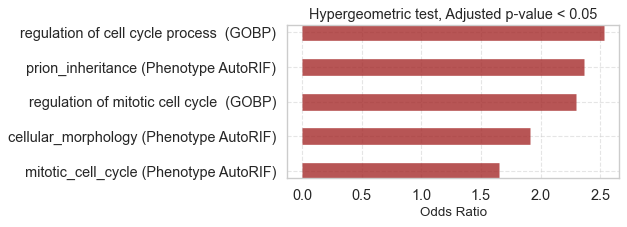

In [23]:
sns.set(font_scale=1)
sns.set_style("whitegrid")

# Color based on p-value
combined_fisher['colors'] = ['brown' if float(x) < 0.05 else 'rosybrown' for x in combined_fisher['Adjusted P-value']] 

# Sort values from lowest to highest 
combined_fisher.sort_values('Odds Ratio', ascending=True, inplace=True) 

# Draw plot 
plt.figure(figsize=(8, 3), dpi=80) 
# Plotting the horizontal lines 
plt.hlines(y=combined_fisher.Term_short + ' ('+ combined_fisher.Ontology + ')', xmin=0, xmax=combined_fisher['Odds Ratio'], color=combined_fisher['colors'], alpha=0.8, linewidth=15) 

# Setting Date to y-axis 
plt.yticks(combined_fisher.Term_short + ' ('+ combined_fisher.Ontology + ')', fontsize=13) 
plt.xticks(fontsize=13) 
plt.xlabel('Odds Ratio', fontsize=12)

# Optional grid layout 
plt.grid(linestyle='--', alpha=0.5) 
plt.title('Hypergeometric test, Adjusted p-value < 0.05', fontsize= 13)

#brown_patch = mpatches.Patch(color='brown', label='adj. pvalue < 0.05')
# rosybrown_patch = mpatches.Patch(color='rosybrown', label='adj. pvalue < 0.1')
#plt.legend(handles=[brown_patch, rosybrown_patch], loc='lower right')

# Displaying the Diverging Bar Chart 
plt.tight_layout()
plt.savefig('plots/plot_fisher_adjpval01.svg')
plt.show() 

# GSEA test on MoBy logFC defined RANK

In [24]:
DF['rank'] = -np.log10(DF.FDR)*DF.logFC
rank = DF[['rank']]
rank.columns = range(rank.shape[1])
rank = rank.sort_values(by= 0)

In [25]:
# Rank for collection with systematic name 
rank_sys = DF[['Systematic name','rank']]
rank_sys = rank_sys.set_index('Systematic name')
rank_sys.columns = range(rank_sys.shape[1])
rank_sys = rank_sys.sort_values(by= 0)

enr = gp.prerank(rnk=rank_sys,
                     gene_sets= other_libraries,
                     threads=4,
                     min_size=5,
                     max_size=2000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir= None,
                     seed=41,
                     verbose=True, # see what's going on behind the scenes
                    )

2024-04-04 13:22:16,972 [INFO] Parsing data files for GSEA.............................
2024-04-04 13:22:16,976 [INFO] 0002 gene_sets have been filtered out when max_size=2000 and min_size=5
2024-04-04 13:22:16,978 [INFO] 0004 gene_sets used for further statistical testing.....
2024-04-04 13:22:16,979 [INFO] Start to run GSEA...Might take a while..................
2024-04-04 13:22:17,618 [INFO] Congratulations. GSEApy runs successfully................



In [26]:
enr.res2d

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,is essential,0.688339,1.322045,0.158491,0.148305,0.068,3/8,14.88%,YHR122W;YNL181W;YPR015C
1,prerank,has disordered region,-0.511038,-1.035019,0.389,1.0,0.83,35/182,17.08%,YLR125W;YLR030W;YBR241C;YGR067C;YKL050C;YMR295...
2,prerank,has transmembrane domain,-0.411289,-0.826425,0.923,1.0,0.996,21/149,18.29%,YOL163W;YBR241C;YNR066C;YPR071W;YHR078W;YNR021...
3,prerank,is in complex,-0.419417,-0.702391,0.89029,0.943311,0.999,2/12,12.95%,YDR131C;YKR023W


In [27]:
libr = [go_bp, go_cc, go_mf, pfam, pheno, kegg, interpro, ppi, wiki, prion_lib, other_libraries]
name_libr = ['GOBP', 'GOCC', 'GOMF', 'PFAM', 'Phenotype AutoRIF', 'KEGG', 'INTER-PRO', 'PPI HUBS', 'Wiki pathway', 'Prion-like', 'Other gene sets']
gsea_enrichments = []
for x in range(len(libr)): 
    enr = gp.prerank(rnk=rank,
                     gene_sets= libr[x],
                     threads=4,
                     min_size=5,
                     max_size=2000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir= 'GSEA_results/' + name_libr[x], 
                     seed=41,
                     verbose=True, # see what's going on behind the scenes
                    )
    gsea_enrichments.append(enr)

2024-04-04 13:22:17,657 [INFO] Parsing data files for GSEA.............................
2024-04-04 13:22:17,668 [INFO] 0262 gene_sets have been filtered out when max_size=2000 and min_size=5
2024-04-04 13:22:17,669 [INFO] 1387 gene_sets used for further statistical testing.....
2024-04-04 13:22:17,670 [INFO] Start to run GSEA...Might take a while..................
2024-04-04 13:22:51,907 [INFO] Start to generate gseapy reports, and produce figures...
2024-04-04 13:22:51,911 [INFO] Congratulations. GSEApy runs successfully................

2024-04-04 13:22:51,957 [INFO] Parsing data files for GSEA.............................
2024-04-04 13:22:51,968 [INFO] 0030 gene_sets have been filtered out when max_size=2000 and min_size=5
2024-04-04 13:22:51,970 [INFO] 0277 gene_sets used for further statistical testing.....
2024-04-04 13:22:51,972 [INFO] Start to run GSEA...Might take a while..................
2024-04-04 13:22:58,148 [INFO] Start to generate gseapy reports, and produce figures...


2024-04-04 13:24:29,198 [INFO] Parsing data files for GSEA.............................
2024-04-04 13:24:29,200 [INFO] 0000 gene_sets have been filtered out when max_size=2000 and min_size=5
2024-04-04 13:24:29,201 [INFO] 0001 gene_sets used for further statistical testing.....
2024-04-04 13:24:29,202 [INFO] Start to run GSEA...Might take a while..................
2024-04-04 13:24:31,463 [INFO] Start to generate gseapy reports, and produce figures...
2024-04-04 13:24:31,465 [INFO] Congratulations. GSEApy runs successfully................

2024-04-04 13:24:31,480 [INFO] Parsing data files for GSEA.............................
2024-04-04 13:24:31,483 [INFO] 0001 gene_sets have been filtered out when max_size=2000 and min_size=5
2024-04-04 13:24:31,484 [INFO] 0005 gene_sets used for further statistical testing.....
2024-04-04 13:24:31,485 [INFO] Start to run GSEA...Might take a while..................
2024-04-04 13:24:33,194 [INFO] Start to generate gseapy reports, and produce figures...


In [28]:
h_enr = gp.prerank(rnk=rank,
                     gene_sets= {'haploinsufficient': list(haploinsuf.index)} ,
                     threads=4,
                     min_size=5,
                     max_size=2000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir= None, 
                     seed=41,
                     verbose=True) # see what's going on behind the scenes)res2d

2024-04-04 13:24:33,220 [INFO] Parsing data files for GSEA.............................
2024-04-04 13:24:33,226 [INFO] 0000 gene_sets have been filtered out when max_size=2000 and min_size=5
2024-04-04 13:24:33,228 [INFO] 0001 gene_sets used for further statistical testing.....
2024-04-04 13:24:33,229 [INFO] Start to run GSEA...Might take a while..................
2024-04-04 13:24:33,518 [INFO] Congratulations. GSEApy runs successfully................



In [29]:
h_enr.res2d

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,haploinsufficient,-0.533564,-1.071928,0.273,0.273,0.273,24/158,11.30%,RPS5;NUP60;NUP120;LOC1;SUI2;NIP1;RPS15;EAF1;NU...


In [30]:
otherCat = pd.concat([enr.res2d, h_enr.res2d])
otherCat.to_csv('result_datasets/Category_gsea.csv')

In [31]:
# Make a combined dataset, WAS 0.25 BEFORE
# make a dataframe from significant enrichment
combined_gsea = gsea_enrichments[0].res2d[gsea_enrichments[0].res2d['FDR q-val']<=0.05]
combined_gsea['Ontology'] = name_libr[0]
for x in range(1, len(libr)):
    tmp = gsea_enrichments[x].res2d[gsea_enrichments[x].res2d['FDR q-val']<=0.05]
    tmp['Ontology'] = name_libr[x]
    combined_gsea = pd.concat([combined_gsea, tmp], axis=0) 
combined_gsea['Term_short'] = combined_gsea['Term'].str.replace(r"\(.*?\)", "", regex=True)

C:\Users\user\AppData\Local\Temp\ipykernel_41744\3548802098.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Ontology'] = name_libr[x]
C:\Users\user\AppData\Local\Temp\ipykernel_41744\3548802098.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Ontology'] = name_libr[x]


In [32]:
combined_gsea

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,Ontology,Term_short
0,prerank,Sphingolipid Metabolism_WP370,0.781273,1.710788,0.00885,0.034546,0.043,4/11,8.27%,TSC10;AUR1;LCB1;YPC1,Wiki pathway,Sphingolipid Metabolism_WP370
0,prerank,prions,-0.757168,-1.369886,0.031963,0.031963,0.031963,6/20,9.14%,SWI1;NSP1;NUP100;NEW1;YPR022C;KSP1,Prion-like,prions
0,prerank,Prion-like,-0.757168,-1.369886,0.031963,0.028712,0.028,6/20,9.14%,SWI1;NSP1;NUP100;NEW1;YPR022C;KSP1,Other gene sets,Prion-like


C:\Users\user\AppData\Local\Temp\ipykernel_41744\3984480689.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


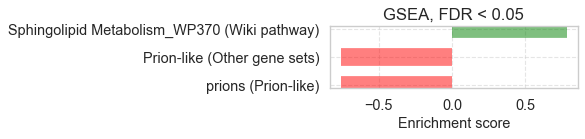

In [33]:
sns.set(font_scale=1)
sns.set_style("whitegrid")

combined_gsea['colors'] = ['red' if float( x) < 0 else 'green' for x in combined_gsea['ES']] 

# Sort values from lowest to highest 
combined_gsea.sort_values('ES', ascending=True, inplace=True) 

# Resets initial index in Dataframe to None 
#combined_gsea.reset_index(inplace=True) 

# Draw plot 
plt.figure(figsize=(4,1), dpi=80) 
# Plotting the horizontal lines 
plt.hlines(y=combined_gsea.Term_short + ' ('+ combined_gsea.Ontology + ')', xmin=0, xmax=combined_gsea['ES'], color=combined_gsea.colors, alpha=0.5, linewidth=16) 

# Decorations 
# Setting the labels of x-axis and y-axis 
#plt.gca().set(xlabel='Enrichment score') 

# Setting Date to y-axis 
plt.yticks(combined_gsea.Term_short + ' ('+ combined_gsea.Ontology + ')', fontsize=13) 
plt.xticks(fontsize=13) 
plt.xlabel('Enrichment score', fontsize=13)

# Optional grid layout 
plt.grid(linestyle='--', alpha=0.5) 
plt.title('GSEA, FDR < 0.05', fontsize= 15)
# Displaying the Diverging Bar Chart 
plt.tight_layout()
plt.savefig('plots/plot_gsea_fdr005.svg')
plt.show() 

# Add gene description

In [34]:
# Add gene description
import pickle
with open('datasets/SGD_R58_gene_descs.p', 'rb') as file:
    annot = pickle.load(file)
DF['NAME'] = DF['Systematic name'].map(annot)
combined_gsea.to_csv('GSEA_results/gsea_rank_summary_fdr025.csv')
combined_fisher.to_csv('GSEA_results/hypergeometric_test_summary_adjpval01.csv')

## Prion analysis

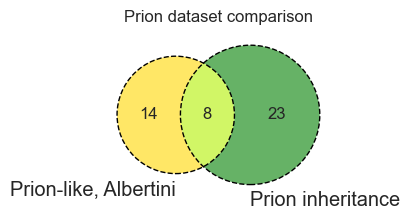

In [35]:
plt.figure(figsize = (3, 3))
venn2([set(prions) , set(pheno['prion_inheritance'])], ('Prion-like, Albertini', 'Prion inheritance'), set_colors=("gold", 
                             "green"),alpha=0.6)
venn2_circles([set(prions) , set(pheno['prion_inheritance'])],  
              linestyle="dashed", linewidth=1) 
plt.title('Prion dataset comparison')
plt.show() 

In [36]:
# DF[DF.index.isin(prions)].to_csv('result_datasets/prions_like_albertini_logFC.csv')

### Combine the 2 lists

In [37]:
prions_common = list(set(prions) & set(pheno['prion_inheritance']))
prions_comb = list(set(list((prions)) + list(pheno['prion_inheritance'])))

alb_pheno = set(prions) - set(pheno['prion_inheritance'])
pheno_alb = set(pheno['prion_inheritance']) - set(prions) 

prion_lib = {'Prion, Unique Albertini': alb_pheno, 
             'Prion, Unique phenotypeAutoRIF': pheno_alb, 
             'Prion, inheritance (pheno)': pheno['prion_inheritance'],
             'Prion, Albertini & PhenoAutoRIF, common': prions_common,
             'Prion, Alberini + PhenoAutoRIF': prions_comb,
            'Prion, Albertini': prions}

In [38]:
enr = gp.prerank(rnk=rank,
                     gene_sets= prion_lib,
                     threads=4,
                     min_size=5,
                     max_size=2000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir= None,
                     seed=41,
                     verbose=True, # see what's going on behind the scenes
                    )
enr.res2d

2024-04-04 13:24:34,127 [INFO] Parsing data files for GSEA.............................
2024-04-04 13:24:34,129 [INFO] 0000 gene_sets have been filtered out when max_size=2000 and min_size=5
2024-04-04 13:24:34,130 [INFO] 0006 gene_sets used for further statistical testing.....
2024-04-04 13:24:34,132 [INFO] Start to run GSEA...Might take a while..................
2024-04-04 13:24:34,514 [INFO] Congratulations. GSEApy runs successfully................



,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,"Prion, inheritance (pheno)",-0.736106,-1.373088,0.03125,0.191075,0.108652,13/23,18.62%,PMA1;SWI1;TSA1;NUP100;NEW1;MOD5;SSA2;SSA1;YDJ1...
1,prerank,"Prion, Alberini + PhenoAutoRIF",-0.70855,-1.37279,0.017876,0.096127,0.109658,13/36,12.82%,PMA1;SWI1;NSP1;TSA1;NUP100;NEW1;YPR022C;MOD5;K...
2,prerank,"Prion, Albertini",-0.757168,-1.369886,0.031963,0.068017,0.113682,6/20,9.14%,SWI1;NSP1;NUP100;NEW1;YPR022C;KSP1
3,prerank,"Prion, Albertini & PhenoAutoRIF, common",-0.848499,-1.326673,0.066667,0.091409,0.195171,3/7,6.79%,SWI1;NUP100;NEW1
4,prerank,"Prion, Unique phenotypeAutoRIF",-0.703599,-1.253759,0.135006,0.166542,0.352113,9/16,18.62%,PMA1;TSA1;MOD5;SSA2;SSA1;YDJ1;SSZ1;HOF1;EST2
5,prerank,"Prion, Unique Albertini",-0.682709,-1.173389,0.266423,0.254374,0.544266,3/13,9.14%,NSP1;YPR022C;KSP1


In [39]:
prion_enr = gp.enrich(gene_list=list(toxic.index), # or gene_list=glist
                 gene_sets=prion_lib, 
                 background=list(DF.index), 
                 outdir= None, # 'GSEA_results/Fisher_' + name_libr[x],
                 verbose=True)
prion_enr.res2d

2024-04-04 13:24:34,537 [INFO] Input dict object named with gs_ind_0
2024-04-04 13:24:34,539 [INFO] Run: gs_ind_0 
2024-04-04 13:24:34,545 [INFO] Done.


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
0,gs_ind_0,"Prion, Alberini + PhenoAutoRIF",20/36,0.000468,0.001403,2.013865,15.441548,HOF1;TSA1;PMA1;NEW1;MOT3;RLM1;PUB1;YPR022C;NUP...
1,gs_ind_0,"Prion, Albertini",9/20,0.079506,0.119259,1.652926,4.185086,MOT3;RLM1;PUB1;YPR022C;NUP100;KSP1;NEW1;SWI1;NSP1
2,gs_ind_0,"Prion, Albertini & PhenoAutoRIF, common",4/7,0.102623,0.123148,2.137785,4.867080,NUP100;SWI1;MOT3;NEW1
3,gs_ind_0,"Prion, Unique Albertini",5/13,0.289735,0.289735,1.450788,1.797221,RLM1;PUB1;YPR022C;KSP1;NSP1
4,gs_ind_0,"Prion, Unique phenotypeAutoRIF",11/16,0.000840,0.001680,2.492220,17.649876,PMA1;SSA1;SSA2;HOF1;TSA1;EST2;TEF2;SSZ1;YDJ1;I...
5,gs_ind_0,"Prion, inheritance (pheno)",15/23,0.000224,0.001342,2.362389,19.857471,PMA1;MOT3;NUP100;SSA1;YDJ1;SSZ1;SSA2;HOF1;TSA1...


## Phenotype SGD, make my own ontology

In [40]:
phenoSGD = pd.read_csv('datasets/phenotype_sgd.tsv', sep='\t', low_memory=False)
phenoSGD = phenoSGD.rename(columns=lambda x: x.replace('Phenotype.', ''))

In [41]:
tmp = DF[['Systematic name']]
tmp['Gene'] = list(tmp.index)

C:\Users\user\AppData\Local\Temp\ipykernel_41744\1251489637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Gene'] = list(tmp.index)


In [42]:
phenoSGD = phenoSGD.rename(columns={'genes.secondaryIdentifier': 'Systematic name'})
phenoSGD = pd.merge(phenoSGD, tmp, on='Systematic name')

In [43]:
pheno_Over= phenoSGD[phenoSGD['mutantType'] == 'overexpression']
pheno_repr= phenoSGD[phenoSGD['mutantType'].isin(['reduction of function', 'repressible', 'dominant negative'])]

In [44]:
pheno_Over = pheno_Over[pheno_Over['condition'] == ' ']
pheno_repr = pheno_repr[pheno_repr['condition'] == ' ']

In [45]:
# phenotypes with more than 5 genes
pheno_lO = pheno_Over['observable'].value_counts()
pheno_lO = pheno_Over['observable'].value_counts().to_frame()
pheno_lO = pheno_lO[pheno_lO['count'] >= 3]
pheno_lO = list(pheno_lO.index)

pheno_lR = pheno_repr['observable'].value_counts()
pheno_lR = pheno_repr['observable'].value_counts().to_frame()
pheno_lR = pheno_lR[pheno_lR['count'] >= 3]
pheno_lR = list(pheno_lR.index)

In [46]:
pheno_l = phenoSGD['observable'].value_counts().to_frame()
pheno_l = pheno_l[pheno_l['count'] >= 3]
pheno_l = list(pheno_l.index)

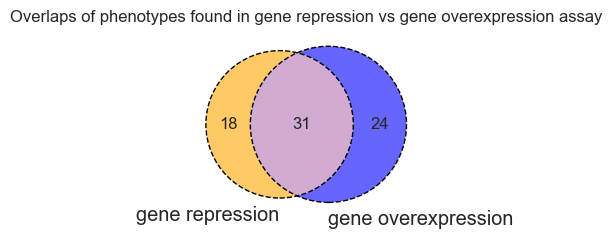

In [47]:
from matplotlib_venn import venn2, venn2_circles
plt.figure(figsize = (3, 3))
venn2([set(pheno_lR), set(pheno_lO)], ('gene repression', 'gene overexpression'), set_colors=("orange", 
                             "blue"),alpha=0.6)
venn2_circles([set(pheno_lR), set(pheno_lO)],  
              linestyle="dashed", linewidth=1) 
plt.title('Overlaps of phenotypes found in gene repression vs gene overexpression assay')
plt.show() 

In [48]:
over_pheno = {}
for p in pheno_lO:
    tmp = pheno_Over[pheno_Over['observable'] == p]
    over_pheno[p] = list(set(tmp['Gene']))

In [49]:
repr_pheno = {}
for p in pheno_lR:
    tmp = pheno_repr[pheno_repr['observable'] == p]
    repr_pheno[p] = list(set(tmp['Gene']))

In [50]:
all_pheno = {}
for p in pheno_l:
    tmp = phenoSGD[phenoSGD['observable'] == p]
    all_pheno[p] = list(set(tmp['Gene']))

In [51]:
gene_phenoSGD_res = gp.prerank(rnk=rank,
                     gene_sets=all_pheno,
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir='GSEA_results/SGD_phenotype_gene_phenotype', # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )
gene_phenoSGD_res.res2d.head(10)

2024-04-04 13:24:37,020 [INFO] Parsing data files for GSEA.............................
2024-04-04 13:24:37,034 [INFO] 0028 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-04-04 13:24:37,037 [INFO] 0131 gene_sets used for further statistical testing.....
2024-04-04 13:24:37,039 [INFO] Start to run GSEA...Might take a while..................
2024-04-04 13:24:47,217 [INFO] Start to generate gseapy reports, and produce figures...
2024-04-04 13:24:47,218 [INFO] Congratulations. GSEApy runs successfully................



,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,bipolar budding pattern,0.687838,1.533826,0.06,0.244299,0.256,6/12,21.18%,RPS7A;CDC10;CDC5;IQG1;CDC11;CDC12
1,prerank,mitochondrial transport,0.836084,1.470391,0.031153,0.210146,0.411,3/6,7.96%,SAM35;MIC60;SAM50
2,prerank,apoptosis,-0.718978,-1.406524,0.005092,0.779388,0.529,11/47,12.12%,RAD54;COX12;PKH1;IZH3;SKN1;SMC3;PDE2;SGS1;MSH2...
3,prerank,size of nucleus,-0.905464,-1.352803,0.037821,1.0,0.863,1/5,6.28%,WHI5
4,prerank,colony size,0.803462,1.349525,0.105882,0.331358,0.708,2/5,2.44%,ATG32;INP51
5,prerank,vacuolar transport,-0.715247,-1.340209,0.031847,0.829179,0.906,5/28,13.25%,AVT1;LDB19;STP22;STB2;SNF7
6,prerank,cytoskeleton morphology,-0.783408,-1.337714,0.053683,0.650845,0.916,5/12,14.52%,BUD4;BIK1;CCT3;SPC72;SPC97
7,prerank,RNA localization,-0.742479,-1.322991,0.064706,0.651962,0.96,4/15,10.53%,NUP60;RRP6;SCP160;XRN1
8,prerank,nuclear position,-0.737614,-1.306241,0.096471,0.679805,0.985,7/15,16.54%,TUB2;MDM1;CCT3;CIK1;SPC72;SPC97;BUD6
9,prerank,X ray resistance,-0.683823,-1.270033,0.090909,0.904955,0.997,7/28,14.61%,RAD54;RAD55;EAF1;RAD61;RAD5;DCC1;SRS2


In [52]:
gene_OP_res = gp.prerank(rnk=rank,
                     gene_sets=over_pheno,
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir='GSEA_results/SGD_overexp_gene_phenotype', # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )
gene_OP_res.res2d.head(10)

2024-04-04 13:24:47,257 [INFO] Parsing data files for GSEA.............................
2024-04-04 13:24:47,261 [INFO] 0015 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-04-04 13:24:47,263 [INFO] 0040 gene_sets used for further statistical testing.....
2024-04-04 13:24:47,265 [INFO] Start to run GSEA...Might take a while..................
2024-04-04 13:24:50,940 [INFO] Start to generate gseapy reports, and produce figures...
2024-04-04 13:24:50,941 [INFO] Congratulations. GSEApy runs successfully................



,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,protein activity,-0.934125,-1.489523,0.001395,0.045326,0.046,2/8,1.21%,SOD2;PMA1
1,prerank,oxidative stress resistance,0.581459,1.468326,0.09375,0.357926,0.246,8/21,23.08%,UBC4;PEX4;TPO1;YFH1;UBC9;UBC8;RAD6;ECL1
2,prerank,actin cytoskeleton morphology,-0.723918,-1.335275,0.053288,0.599841,0.693,5/22,13.25%,MPS1;SNQ2;ADY4;CTR1;SNF7
3,prerank,bud neck morphology,0.76463,1.298461,0.174194,0.499578,0.521,1/5,12.37%,IQG1
4,prerank,nuclear morphology,-0.63375,-1.230263,0.093525,1.0,0.981,14/49,14.93%,BIK1;TUB2;TEA1;CNM67;RPC82;FTR1;CLB3;CLB2;YHR1...
5,prerank,vacuolar morphology,-0.628689,-1.218508,0.141675,1.0,0.985,8/40,11.86%,YOL159C-A;SNA2;STP22;ADY4;GYP7;FRK1;STE4;CLB6
6,prerank,metal resistance,-0.604991,-1.217924,0.002,0.911913,0.985,76/317,15.19%,BIK1;TUB2;LDB19;MGA1;ECM23;SAM3;BAS1;NEO1;KIP1...
7,prerank,competitive fitness,-0.602511,-1.217034,0.005,0.765553,0.986,78/274,18.60%,TUB2;DUO1;MGA1;ECM23;ROM1;FMP48;BAS1;KIP1;RAD2...
8,prerank,hyperosmotic stress resistance,-0.609918,-1.214756,0.096251,0.672169,0.986,16/68,14.07%,GTS1;TRE1;ADH4;PFS1;PRM2;NDT80;MAF1;PNG1;MRF1;...
9,prerank,replicative lifespan,-0.659288,-1.197997,0.216155,0.677594,0.992,2/19,0.74%,VMA1;AVT1


In [53]:
gene_RP_res = gp.prerank(rnk=rank,
                     gene_sets=repr_pheno,
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir='GSEA_results/SGD_repre_gene_phenotype', # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )
gene_RP_res.res2d.head(10)

2024-04-04 13:24:50,979 [INFO] Parsing data files for GSEA.............................
2024-04-04 13:24:50,983 [INFO] 0017 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-04-04 13:24:50,987 [INFO] 0032 gene_sets used for further statistical testing.....
2024-04-04 13:24:50,988 [INFO] Start to run GSEA...Might take a while..................
2024-04-04 13:24:54,074 [INFO] Start to generate gseapy reports, and produce figures...
2024-04-04 13:24:54,076 [INFO] Congratulations. GSEApy runs successfully................



,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,protein/peptide modification,0.666663,1.583316,0.02069,0.091751,0.072,4/16,13.96%,LCB1;NUS1;ADA2;UBC9
1,prerank,chronological lifespan,0.777777,1.333544,0.151786,0.417103,0.489,2/5,17.73%,LCB1;IDS2
2,prerank,replicative lifespan,-0.800832,-1.327708,0.067097,1.0,0.668,3/10,3.41%,NUP60;PMA1;IFH1
3,prerank,protein/peptide distribution,-0.633098,-1.209793,0.151323,1.0,0.979,6/34,8.43%,BIK1;TUB2;ERG26;RET3;SEC15;MYO2
4,prerank,metal resistance,-0.780148,-1.209586,0.202667,1.0,0.979,5/7,17.21%,YAH1;CTR1;ARP3;PIF1;PMR1
5,prerank,cell cycle progression in S phase,-0.618219,-1.174516,0.223784,1.0,0.993,5/31,7.93%,ERG26;SMC4;TRS120;POL2;DPB11
6,prerank,vegetative growth,-0.586995,-1.155612,0.195147,1.0,0.996,13/62,15.37%,TUB2;SUA7;NEO1;RRN3;YAH1;MTR4;THS1;CYR1;YDJ1;E...
7,prerank,vacuolar morphology,-0.770226,-1.136299,0.339909,1.0,0.997,3/5,22.48%,VPS35;VPS8;VTC4
8,prerank,respiratory growth,-0.649954,-1.131534,0.333333,1.0,0.998,3/14,8.25%,AEP3;SDH1;CTR1
9,prerank,inviable,-0.614248,-1.11743,0.339227,0.996763,0.999,5/21,20.17%,NEO1;MTR4;KAP120;BRF1;SPC25


In [54]:
combined_gsea['Description'] = combined_gsea['Term'] + ' (from ' + combined_gsea['Ontology'] + '), Enrichment score: ' + combined_gsea['ES'].astype(str) + ', p-value = ' + combined_gsea['NOM p-val'].astype(str)
combined_fisher['Description'] = combined_fisher['Term'] + ' (from ' + combined_fisher['Ontology'] + '),  Odds Ratio: ' + combined_fisher['Odds Ratio'].astype(str) + ',adj. p-value = ' + combined_fisher['Adjusted P-value'].astype(str) 

# Add the significant features to the dataset

In [55]:
dic_name_libr = {}
for x in range(len(name_libr)):
    dic_name_libr[name_libr[x]] = libr[x]

In [56]:
# From gsea and fisher test
for i, row in combined_fisher.iterrows():
    t = row['Term']
    DF[t] = 0
    genes = dic_name_libr[row['Ontology']][t]
    for gene in genes:
        if gene in DF.index:
            DF.loc[gene,t] = 1

In [57]:
# From gsea and fisher test
for i, row in combined_gsea.iterrows():
    t = row['Term']
    DF[t] = 0
    genes = dic_name_libr[row['Ontology']][t]
    for gene in genes:
        if gene in DF.index:
            DF.loc[gene,t] = 1

In [58]:
DF.drop(['FC', 'GOMF', 'GOBP slim','GOCC slim', 'fopScore', 'Introns median length',  'Sum d0 Pause Score'], axis=1, inplace=True)

In [59]:
DF.to_csv('result_datasets/Moby_genes_features_GSEA.csv')